# A tutorial for running a landslide runout simulation

This tutorial is written as a Jupyter notebook and provides a step-by-step tutorial for setting up a landslide runout model and plot its outputs. We will use the sample data included in the synxflow package. The notebook can be downloaded from [Github](https://github.com/SynxFlow/SynxFlow/blob/master/docs/source/Tutorials/landslide.ipynb).

[![Run a landslide model](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1D_Y0-NOyNBuDAKISqiPtGClNe5mRybsF?usp=sharingg)

Authors: 
[Xilin Xia](https://www.birmingham.ac.uk/staff/profiles/civil/xia-xilin.aspx)

Date: 21/12/2023

## Explaining the data

The first step is to list which data is included in the sample.

In [1]:
from synxflow import IO
import os
from synxflow.IO.demo_functions import get_sample_data
dem_file, demo_data, data_path = get_sample_data(case_type ='landslide') # get the path of sample data
os.listdir(data_path)

['depth.gz', 'dem.gz']

As we can see from the list, there are 2 files in the folder. Both of them are zipped ArcGIS ASCII format raster. 'dem.gz' defines the topography while 'depth.gz' defines the depth of the initial landslide mass.

 We can use the 'Raster' and 'mapshow' functions built in synxflow to visualise them. As we can see from the figure, the DEM represents a slope joining a horizontal plate. The depth represents 1 m thick material on the top of the slope.

(<Figure size 640x480 with 2 Axes>, <Axes: >)

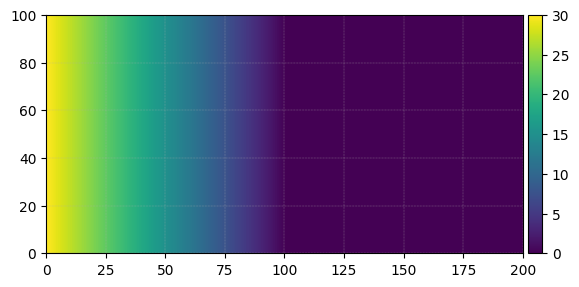

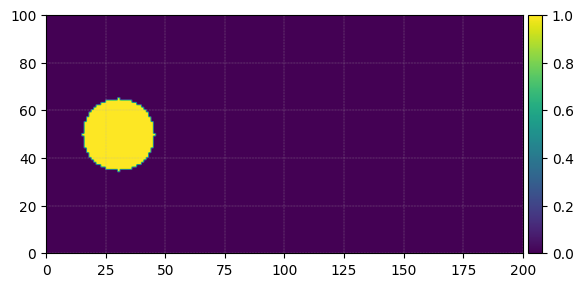

In [3]:
DEM = IO.Raster(os.path.join(data_path,'dem.gz'))
DEM.mapshow()
Depth = IO.Raster(os.path.join(data_path,'depth.gz'))
Depth.mapshow()

## Generating the inputs and runing the simulation

We will now use the data we have just loaded to set up a flood model. In the first step, we need to initialise an InputModel object with the DEM. We also want to specify the directory where the simulation is run and the number of devices we want to use. The landslide runout solver only supports single GPU now.

In [4]:
case_folder = os.path.join(os.getcwd(), 'landslide_case') # define a case folder in the current directory
case_input = IO.InputModel(DEM, num_of_sections=1, case_folder=case_folder)

We can then set the initial depth for the landslide. In our case, the initial depth is taken from the sample data.

In [5]:
case_input.set_initial_condition('h0', Depth.array)

We also need set up a few additional parameters. The following table explains them

| Parameters               | Values |
|--------------------------|--------|
| `rheology_type`          | 1 - Mohr-Coulomb<br>2 - &mu;I rheology |
| `rheology_params`        | An array defining the parameters:<br>- If `rheology_type` is 1, use [friction coefficient, cohesion (kPa), density (kg/m^3)].<br>- If `rheology_type` is 2, use [friction coefficient &mu;1, friction coefficient &mu;2, characteristic length (m), dimensionless coefficient &beta;]. |
| `gravity_correction_type`| 0 - No gravity correction<br>1 - Gravity correction using slope gradient<br>2 - Gravity correction using slope and surface gradient |
| `curvature_on`           | `True` - Include centrifugal force due to bed curvature<br>`False` - Do not include centrifugal force due to bed curvature |

Explanations of the rheology, gravity correction and curvature effects can be found in [Xia and Liang (2018)](https://www.sciencedirect.com/science/article/pii/S0013795217306324).

In [6]:
case_input.write_landslide_config(rheology_type = 1, rheology_params = [0.2, 0, 2000], gravity_correction_type = 1, curvature_on = True)

We can then set up the runtime and write the inputs similar to the flood model.

In [7]:
case_input.set_runtime([0, 20, 5, 20]) # start time (s), total simulation time (s), output interval (s), back up interval (s)
case_input.write_input_files()

times_setup.dat created
device_setup.dat created
z created
h created
hU created
precipitation created
manning created
sewer_sink created
cumulative_depth created
hydraulic_conductivity created
capillary_head created
water_content_diff created
precipitation_mask created
precipitation_source_all.dat created
boundary condition files created
gauges_pos.dat created


Finally let's run the simulation.

In [8]:
from synxflow import landslide
landslide.run(case_folder)

GPU 0 is choosen as the model device

0


Read in mesh successfully
Read in field successfully
Current time: 0s
Total time: 20s
Output time interval: 5s
Backup interval: 20s
0.200000 0.000000 2000.000000
Read in configuration successfully
0
0.005
0.171162
...
19.9472
19.9868
20
Writing output files
Writing backup files
Total runtime 246.798ms


## Plotting the results

After the simulation finishes, we can visualise the runout process. This is done by plotting the depths at different times. As can be seen from the figures, the initial mass of the landslide runs fast along the slope before depositing at the bottom of the slope.

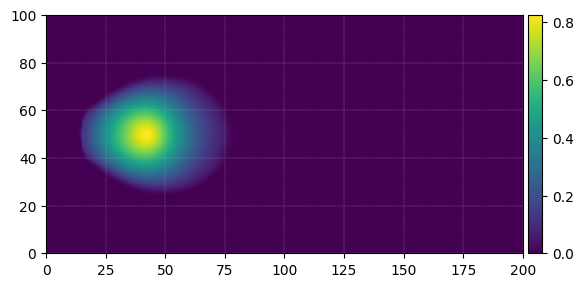

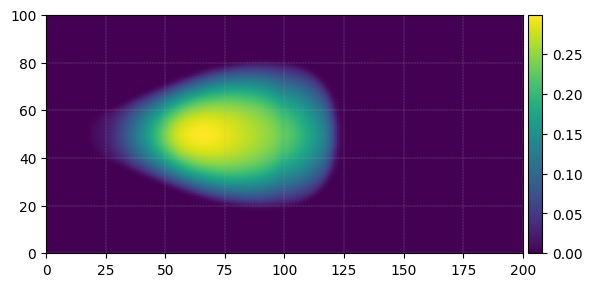

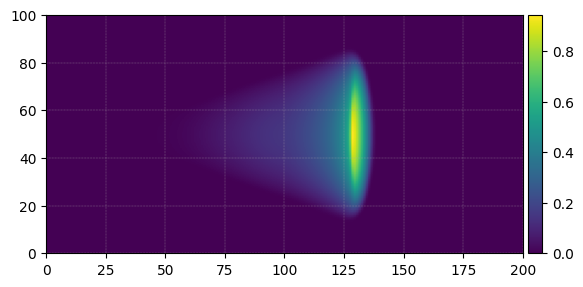

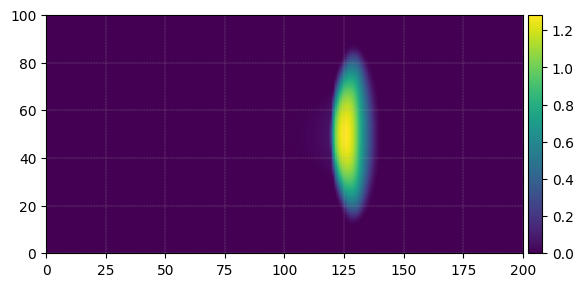

In [11]:
case_output = IO.OutputModel(input_obj = case_input)
for name in ['h_5','h_10','h_15','h_20']:
    depth = case_output.read_grid_file(file_tag=name)
    depth.mapshow()